In [1]:
BASEDIR = 'C:/Users/BZ241WX/Projects/Lab/External/'

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import pandas

from sklearn import metrics
import numpy as np
import os
from fbprophet import Prophet




pandas.plotting.register_matplotlib_converters()

datapath = '../../Data/TimeSeries/retail_weekly_data.csv'


min_history_date = '2010-01-01'
n_test = 8
n_forecast = 8
seasonal_periods = 12
target_col = 'Weekly_Sales'
forecast_col = 'forecast'
time_col = 'Date'
dfu_col  = 'dfu'
time_format = '%Y-%m-%d'
grain_cols = ['Store', ]
exog_cols = ['IsHoliday', 'Temperature','Fuel_Price', 'MarkDown1',
             'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5',
             'CPI', 'Unemployment',  'Size']

drop_cols=['Type','Dept']
frequency = 'MS'



max_intermittency = 0.2
min_length       = 48
min_completeness = 0.75
max_select_dfus  = 1

random_seed = 2

# Load Data 

In [2]:
df = pandas.read_csv(datapath, sep=';')

df[dfu_col] = df[grain_cols].apply(lambda x: 'StoreDept_'+'-'.join([str(y) for y in x]), axis=1)
df = df.drop(drop_cols, axis=1)
df[time_col] = pandas.to_datetime(df[time_col], format=time_format)

df = df[df[time_col] >= min_history_date]

print('data:', df.shape)
print('cols:', df.columns)

data: (59000, 15)
cols: Index(['Store', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Size', 'dfu'],
      dtype='object')


# Series Metrics

In [3]:
def intermittency(X):
    return (X==0).sum() / X.shape[0]

def completeness(X):
    return 1 - X.isnull().sum() / X.shape[0]

def length(X):
    return X.shape[0]


df_metrics = df.groupby(dfu_col)[target_col].agg([intermittency, completeness, length]).reset_index()

df_metrics.sort_values(['completeness','intermittency','length'], ascending=False).head()

,dfu,intermittency,completeness,length
0,StoreDept_1,0.000293,1.0,10244.0
1,StoreDept_2,0.000195,1.0,10238.0
2,StoreDept_3,0.000111,1.0,9036.0
5,StoreDept_6,0.000098,1.0,10211.0
3,StoreDept_4,0.000000,1.0,10272.0


# Select Series 

In [4]:
idx = ((df_metrics.intermittency <= max_intermittency) &
       (df_metrics.length        >= min_length) &
       (df_metrics.completeness  >= min_completeness))

dfu_list = (df_metrics[idx].sort_values(['completeness','intermittency','length'])
                           .dfu
                           .sample(max_select_dfus, random_state=random_seed)
                           .values)

data = df[df.dfu.isin(dfu_list)].copy()
print(data.shape)

(10238, 15)


# Avoid NaN 

In [5]:
data.fillna(0, inplace=True)
data.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Size            0
dfu             0
dtype: int64

In [6]:
data.dfu.unique()

array(['StoreDept_2'], dtype=object)

# Resolution Change 

In [7]:
exog_agg = {
    'Weekly_Sales': 'sum',
    'IsHoliday': 'sum',
    'Temperature': 'mean',
    'Fuel_Price': 'mean',
    'MarkDown1': 'sum',
    'MarkDown2': 'sum',
    'MarkDown3': 'sum',
    'MarkDown4': 'sum',
    'MarkDown5': 'sum',
    'CPI': 'mean',
    'Unemployment': 'mean',
    'Size': 'mean',
}


data[time_col] = pandas.to_datetime(data[time_col].dt.year.astype(str) + '-' + \
                                    data[time_col].dt.month.astype(str) + '-01',
                                    format='%Y-%m-%d')

agg_data = data.groupby([dfu_col, time_col], as_index=False).agg(exog_agg)


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


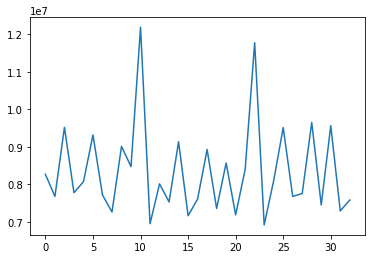

In [8]:
# data.Weekly_Sales.plot()
agg_data.Weekly_Sales.plot()

In [9]:
data.shape
agg_data.shape

(33, 14)

# Train / Test

In [10]:
def split_last_n_by_grain(df, ntest, time_column_name, grain_column_names):
    """Group df by grain and split on last n rows for each group."""
    df_grouped = (df.sort_values(time_column_name) # Sort by ascending time
                  .groupby(grain_column_names, group_keys=False))
    df_head = df_grouped.apply(lambda dfg: dfg.iloc[:-ntest])
    df_tail = df_grouped.apply(lambda dfg: dfg.iloc[-ntest:])
    return df_head, df_tail


df_train, df_test = split_last_n_by_grain(agg_data, n_test, time_col, [dfu_col])


df_train['category'] = 'train'
df_test['category'] = 'test'

batch_result = pandas.concat([df_train, df_test])

print('Train:', df_train.shape)
print('Test:', df_test.shape)

Train: (25, 15)
Test: (8, 15)


# Statistical Forecast Setup

In [11]:
growth = 'linear'
# changepoint_range = 1
# changepoint_prior_scale = 0.5
yearly_seasonality = 12
# weekly_seasonality = False
# daily_seasonality = False
# seasonality_mode = 'additive' # 'multiplicative'
# seasonality_prior_scale = 1
iterations = 100
confidence_interval = .95



Y = df_train[[time_col, target_col]].copy()
Y.columns = ['ds', 'y']
model = Prophet(
    growth=growth,
#     changepoint_range=changepoint_range,
#     yearly_seasonality=yearly_seasonality,
#     weekly_seasonality=weekly_seasonality,
#     daily_seasonality=daily_seasonality,
#     seasonality_mode=seasonality_mode,
#     changepoint_prior_scale=changepoint_prior_scale,
#     seasonality_prior_scale=seasonality_prior_scale,
    interval_width=confidence_interval,
)

model = model.fit(Y, iter=iterations)


forecast_data =model.make_future_dataframe(
            periods=n_test,
            freq=frequency,
            include_history=True
            )

df_forecast = model.predict(forecast_data)
forecast     = df_forecast.yhat.rename('forecast')
forecast_low  =  df_forecast.yhat_lower.rename('forecast_lo')
forecast_up   =  df_forecast.yhat_upper.rename('forecast_up')

batch_result[forecast_col] = forecast.values
batch_result[forecast_col+'_up'] = forecast_up.values
batch_result[forecast_col+'_lo'] = forecast_low.values

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 19.


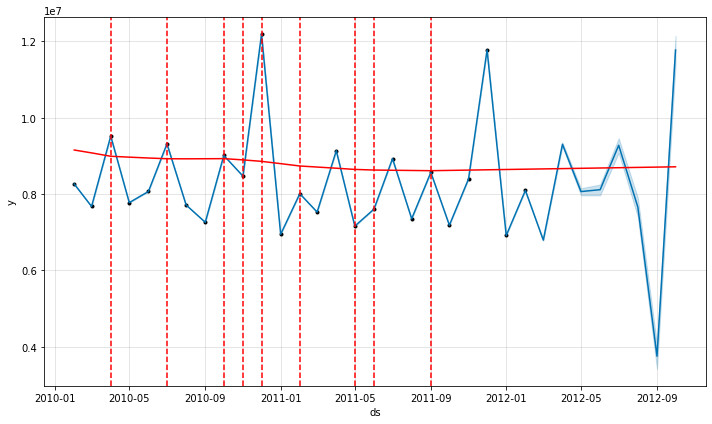

In [12]:
from fbprophet.plot import add_changepoints_to_plot
fig = model.plot(df_forecast)
a = add_changepoints_to_plot(fig.gca(), model, df_forecast)


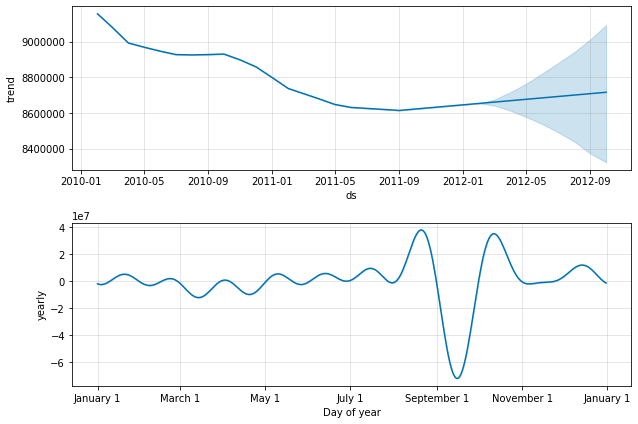

In [13]:
model.plot_components(df_forecast);

# Plot  

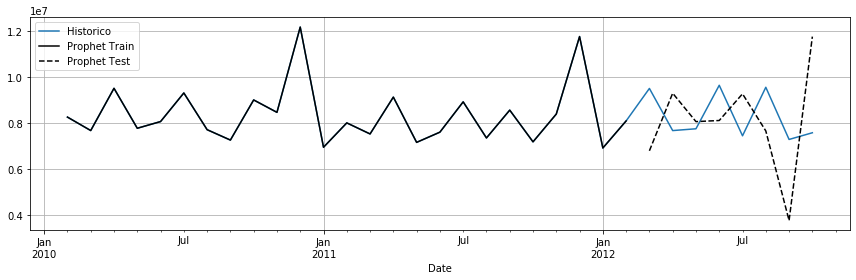

In [14]:
plt.figure(figsize=(12,4))

complete_data = batch_result.copy()

shade_color = '#aaaaaa'

complete_data.groupby(time_col)[target_col].sum().plot(label='Historico')
(complete_data[complete_data.category=='train']
              .groupby(time_col)[forecast_col].sum()
              .plot(color = 'k', ls='-', label='Prophet Train'))

(complete_data[complete_data.category=='test']
              .groupby(time_col)[forecast_col].sum()
              .plot(color = 'k', ls='--', label='Prophet Test'))
    
plt.legend()
plt.grid(True)

plt.tight_layout()

# ML Model 

## Create Target Data 

In [15]:
from statsmodels.tsa.tsatools import lagmat


ml_data = batch_result['forecast_data'].copy()
ml_target = 'target'
ml_data['mes'] = ml_data[time_col].dt.month

stats_forecast_cols = ['forecast_' + m for m in batch_result['score_data'].model_name.unique()]
# ml_variables = exog_cols + stats_forecast_cols + [target_col]
ml_variables = exog_cols + stats_forecast_cols + ['mes']
# ml_variables = exog_cols 


# The value of the next period
def lagged_variables(groups, nlags):
    return lagmat(groups, maxlag = nlags, trim='forward', original='in', use_pandas=True)


ml_data['residual'] = ml_data[target_col] - ml_data['forecast_fb-prophet']

# ml_data[ml_target] = ml_data.groupby(dfu_col)['residual'].shift(-1)
ml_data[ml_target] = ml_data.groupby(dfu_col)[target_col].shift(-1)
ml_data[time_col] = ml_data.groupby(dfu_col)[time_col].shift(-1)
ml_data.dropna(inplace=True, subset=[time_col, ml_target])

# Create lagged features
if True:
    feature_data = ml_data.groupby(dfu_col)[ml_variables].apply(lagged_variables, nlags=2)
    ml_variables = feature_data.columns.tolist()
    for cname in [x for x in ml_variables if x not in ml_data.columns]:
        ml_data[cname] = feature_data[cname].values
    
#     feature_data[dfu_col] = ml_data[dfu_col].copy()
#     feature_data[ml_target] = ml_data[ml_target].copy()
#     feature_data[time_col] = ml_data[time_col].copy()
#     feature_data['category'] = ml_data['category'].copy()
#     ml_data = feature_data.copy()


# ml_data.head()
# ml_data[['dfu','date','history','target']]

KeyError: 'forecast_data'

# Split Train/Test 

In [ ]:
Xtrain = ml_data[ml_data.category == 'train'].set_index(time_col).copy()
Xtest = ml_data[ml_data.category == 'test'].set_index(time_col).copy()

Ytrain = Xtrain[ml_target]
Ytest = Xtest[ml_target]

dfuTrain = Xtrain[dfu_col].copy()
Xtrain = Xtrain[ml_variables].copy()
Xtest  = Xtest[ml_variables].copy()



# Statistical Tests 

In [ ]:
from statsmodels.tsa.stattools import adfuller

df_stat_test_list = []
for vname in ml_variables:
    adf_test = adfuller(ml_data[vname].dropna())
    df_stat_test_list.append([vname, adf_test[0], adf_test[1]])

df_stat_test = pandas.DataFrame(data = df_stat_test_list,
                                columns=['Variable','ADF','Pvalue'])
df_stat_test.head()

# Train Model 

In [ ]:


cvfold = model_selection.StratifiedKFold(n_splits = 4, random_state = 0)


# Configure Pipeline
model_dict = {
    'RandomForest': ensemble.RandomForestRegressor(n_estimators=10, max_features='sqrt'),
#     'LassoLars': LassoLars(),
#     'kNN': KNeighborsRegressor(weights='distance'),
#     'SVM': SVR(gamma='auto'),
}

model_conf = {
    'RandomForest': {
        'Model__max_depth': [3, 4, 6],
        'Model__n_estimators': [3, 5, 10],
    },
    'LassoLars': {
        'Model__alpha': [0.1, 0.3, 1, 5, 10],
    },
    'kNN': {
        'Model__n_neighbors': [3, 4, 5, 10],
    },
    'SVM': {
        'Model__kernel': ['rbf','linear'],
        'Model__C' : [0.1, 1, 10],
    }
}

scorer = metrics.make_scorer(primary_scorer, greater_is_better = False)


ml_model_list = {}


for model_name in model_dict.keys():
    conf_train_pipe = [
        ('Scaler', preprocessing.StandardScaler()),
        ('Model', model_dict[model_name]),
    ]
    
    # Create Pipeline
    model_pipe = pipeline.Pipeline(conf_train_pipe)
    param_grid = model_conf[model_name].copy()
    model_pipe = model_selection.GridSearchCV(model_pipe, param_grid,
                                              scoring=scorer,
                                              fit_params=None,
                                              cv=cvfold.split(Xtrain, dfuTrain),
                                              return_train_score=True,)

    model_pipe.fit(Xtrain, Ytrain)
    ml_model_list[model_name] = model_pipe 
         

# Predict ML Model 

In [ ]:


forecast_model = ForecastModel(**stats_setup)

Y = ml_data[ml_target].copy()
X = ml_data[ml_variables].copy().fillna(0)

test_forecast = ml_data.copy()
test_forecast[ml_target] = Y
for model_name in ml_model_list.keys():
    Yhat_test = ml_model_list[model_name].predict(X)
    test_forecast['ml_forecast_'+model_name] = Yhat_test
#     test_forecast['ml_forecast_'+model_name] = Yhat_test + test_forecast['forecast_fb-prophet']
    
    updated_forecast = forecast_model.apply_forecast_business_rules(
                            (test_forecast['ml_forecast_'+model_name],
                             test_forecast['ml_forecast_'+model_name],
                             test_forecast['ml_forecast_'+model_name]))
    test_forecast['ml_forecast_'+model_name] = updated_forecast[0]


# Scoring 

In [ ]:
test_forecast[test_forecast['category'].isnull()]

In [ ]:

ml_score_list = []
for dfu in test_forecast[dfu_col].unique():
    for mlmodel_name in ml_model_list.keys():
        mltarget_col = 'target'
        mlforecast_col = 'ml_forecast_' + mlmodel_name
        # Loop over scores
        # Evaluate each data_category
        score_data = []
        for data_cat in test_forecast['category'].unique():
            if data_cat == 'future':
                continue
            idx = (test_forecast['category'] == data_cat) & (test_forecast[dfu_col] == dfu)
            Ytest = test_forecast.loc[idx, mltarget_col].values
            Yhat = test_forecast.loc[idx, mlforecast_col].values
            for score_name, scorer in score_list.items():
                # Score model
                score = scorer(Ytest, Yhat, None)
                # Add score to table
                score_data.append([dfu, mlmodel_name, data_cat, score_name, score])
        ml_score_list.append(pandas.DataFrame(data=score_data,
                                              columns=['dfu',
                                                       'model_name',
                                                       'data_category',
                                                       'score_name',
                                                       'score_value']))
ml_score_data = pandas.concat(ml_score_list)
ml_score_data.head()
# ml_score_data[ml_score_data.data_category == 'test']


# Compare Scores

In [ ]:
df_scores = pandas.concat((batch_result['score_data'], ml_score_data))
X=(df_scores[(df_scores.score_name == 'wmape') & (df_scores.data_category == 'test')]
         .groupby(['dfu','data_category','model_name'], as_index=False)
         .score_value
         .mean()
         .sort_values(['dfu','data_category','score_value'], ascending=False)      
)

X.groupby(['dfu', 'model_name']).score_value.mean()

# Scatter-Plot 

In [ ]:
plt.figure()
test_forecast.plot.scatter('target','forecast_fb-prophet',c='k', ax=plt.gca(), label='Statistical')
test_forecast.plot.scatter('target','ml_forecast_RandomForest', c='b', ax=plt.gca(), label='ML')
plt.plot([0, test_forecast.target.max()], [0, test_forecast.target.max()], '-r', label='Ref.')
plt.legend()


# Residual Plot 

In [ ]:
plt.figure()

X = test_forecast.copy()
X['ErrorStat'] = test_forecast.target - test_forecast['forecast_fb-prophet']
X['ErrorML'] = test_forecast.target - test_forecast['ml_forecast_RandomForest']


X.plot.scatter('target', 'ErrorStat',c='k', ax=plt.gca(), label='Statistical')
X.plot.scatter('target','ErrorML', c='b', ax=plt.gca(), label='ML')
plt.plot([0, test_forecast.target.max()], [0, 0], '-r', label='Ref.')
plt.legend()


# Feature IMportance 

In [ ]:
clf = ml_model_list['RandomForest'].best_estimator_.steps[1][1]

idx = np.argsort(clf.feature_importances_)


plt.barh(np.arange(len(ml_variables)), clf.feature_importances_[idx])
plt.yticks(np.arange(len(ml_variables)), np.array(ml_variables)[idx])
plt.title('Feature Importance')

# Plot

In [ ]:
plt.figure(figsize=(12,4))

complete_data = batch_result['forecast_data']

shade_color = '#aaaaaa'

complete_data.groupby(time_col)[target_col].sum().plot(label='Historico')

colors = ['k','r','g','m','y']
for i, model_name in enumerate(batch_result['score_data'].model_name.unique()):
    forecast_col = 'forecast_' + model_name
    dev_forecast_col = 'dev_' + forecast_col
#     (complete_data[complete_data.category=='test']
#                  .groupby(time_col)[dev_forecast_col].sum()
#                  .plot(color = colors[i], ls='-', label=model_name+' Test'))
    (test_forecast.groupby(time_col)[forecast_col].sum()
                  .plot(color = colors[i], ls='-.', label=model_name+' Forecast', marker='o'))


colors = ['k','r','g','m','y']
for i, model_name in enumerate(ml_model_list.keys()):
    (test_forecast.groupby(time_col)['ml_forecast_'+model_name].sum()
                 .plot(color = colors[i], ls='--', label=model_name+' ML', marker='x'))
        
    
plt.legend()
plt.grid(True)

plt.tight_layout()

# SHAP 

In [ ]:
import shap

shap.initjs()
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(ml_model_list[model_name].best_estimator_.steps[1][1])

In [ ]:
plt.figure(figsize=(12,4))

complete_data = batch_result['forecast_data']

shade_color = '#aaaaaa'
dfu_sample = np.random.choice(complete_data.dfu.unique())
idx = complete_data.dfu.isin([dfu_sample])
complete_data[idx].groupby(time_col)[target_col].sum().plot(label='Historico')

colors = ['k','r','g','m','y']
idx = test_forecast.dfu.isin([dfu_sample])

for i, model_name in enumerate(batch_result['score_data'].model_name.unique()):
    (test_forecast[idx].groupby(time_col)['forecast_' + model_name].sum()
                       .plot(color = colors[i], ls='-.', label=model_name+' Forecast', marker='o'))




for i, model_name in enumerate(ml_model_list.keys()):
    (test_forecast[idx].groupby(time_col)['ml_forecast_'+model_name].sum()
                       .plot(color = colors[i], ls='--', label=model_name+' ML Test', marker='x'))
        
    
plt.legend()
plt.title(dfu_sample)
plt.grid(True)

plt.tight_layout()

In [ ]:
plt.figure(figsize=(12,4))
for i, model_name in enumerate(['credito_rural']):
    (test_forecast[idx].groupby(time_col)[model_name].sum()
                       .plot(ls='--', label=model_name))
    
plt.legend()
plt.title(dfu_sample)
plt.grid(True)

plt.tight_layout()              

In [ ]:
dfu_sample
date_sample = '2018-06-01'

X = ml_data[(ml_data.dfu == dfu_sample) & (ml_data[time_col] == date_sample)][ml_variables]

shap_values = explainer.shap_values(X)
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values, X, feature_names = ml_variables)


In [ ]:


X = ml_data[(ml_data.dfu == dfu_sample)][ml_variables]
shap_values = explainer.shap_values(X)
shap.force_plot(explainer.expected_value, shap_values, X, feature_names=ml_variables)

In [ ]:
ivar = 0
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot(ml_variables[ivar], shap_values, X, feature_names=ml_variables)

In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X, feature_names=ml_variables)